# DFL applied to extended ROA analysis

In [1]:
from darli.models import RobotModel     # Rofl, bez nee casadi ne importiruetsya
import casadi as cs
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp
from utils import draw_elipse, phase_portrait, sampling_roa

## Inverted time Van der Pol oscillator

The equation is:
$$\ddot{x} = -(1-x^2)\dot{v} - x + u$$

For the DFL linearization, let's choose:
$$\eta = \begin{bmatrix} x^2 \dot{x} \end{bmatrix}.$$


If we introduce $q = \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$
Then, the equation would be:
$$\dot{q} = \begin{bmatrix} 0 & 1 \\ -1 & -1 \end{bmatrix} q + \begin{bmatrix} 0 \\ 1 \end{bmatrix} \eta + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u \equiv A_q q + A_\eta \eta + Bu$$


In [2]:
nx, nv, neta = 1, 1, 1

x = cs.SX.sym('x', nx)
v = cs.SX.sym('v', nv)
dv = cs.SX.sym('dv', nv)

state = cs.vertcat(x, v)
state_dot = cs.vertcat(v, dv)

In [3]:
# Inverted-time Van der Pol no. 1
f = cs.Function("f", [state], [cs.vertcat(v, -(1-x**2)*v - x)])
eta = x**2 * v
A_x = np.array([[0, 1], [-1, -1]])
A_eta = np.array([0, 1]).reshape(-1, 1)

# Inverted-time Van der Pol no. 2
# f = cs.Function("f", [state], [cs.vertcat(v, -x-v + (x**3)/3)])
# eta = x**3 / 3
# A_x = np.array([[0, 1], [-1, -1]])
# A_eta = np.array([0, 1]).reshape(-1, 1)

# Pendulum
# f = cs.Function("f", [state], [cs.vertcat(v, -9.81 * cs.sin(x))])
# eta = -cs.sin(x)
# A_x = np.array([[0, 1], [0, 0]])
# A_eta = np.array([0, 9.81]).reshape(-1, 1)


In [4]:
# There would be two types of symbolic etas: eta(x) and eta as free variable
# It's important to note where which variable is used
eta_sym = cs.SX.sym('eta', neta)

In [5]:
eta_fn = cs.Function("eta", [state], [eta])

# State + auxiliary variables
full_state = cs.vertcat(state, eta)
full_state_sym = cs.vertcat(state, eta_sym)

In [6]:
# Verification that matrices are chosed correctly
f_lin = cs.Function("f_lin", [state], [A_x @ state + A_eta @ eta])

state_np = np.random.uniform(-2, 2, size=(2,))

f_lin(state_np), f(state_np)

(DM([1.17705, 4.92072]), DM([1.17705, 4.92072]))

### Data sampling

In [7]:
# Simulation parameters
dt_sim = 1e-3
dt_sample = 1e-2
n_samples = 100
t_end = 10
x_range = (-5, 5)

In [8]:
!pip install -q tqdm

In [9]:
ts = np.arange(0, t_end, dt_sim)
save_each = int(dt_sample / dt_sim)
state_samples = []

f_np = lambda t, x: np.array(f(x)).ravel()

progress_bar = tqdm(total=n_samples)

while len(state_samples) < n_samples:
    state_np = np.random.uniform(*x_range, size=(2,))
    sol = solve_ivp(
        f_np,
        (0, t_end),
        state_np,
        t_eval=ts
    )
    if sol.status == 0:
        progress_bar.update(1)
        state_samples.append(sol.y.T[::save_each])
progress_bar.close()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


In [10]:
state_np = np.concatenate(state_samples, axis=0)
v_dot_np = np.array([
    f_np(0, state_i) for state_i in state_np
])
# It's not multiple of n_samples, because some samples diverged and did not finish the iteration
state_np.shape

(100000, 2)

In [11]:
eta_dot = cs.jacobian(eta, state) @ cs.vertcat(v, dv)
eta_dot_fn = cs.Function(
    "eta_dot", 
    [state, dv], 
    [
        eta_dot
    ]
)

eta_np = np.array([
    eta_fn(state_i) for state_i in state_np
])[:, :, 0]

In [12]:
eta_dot_np = np.array([
    eta_dot_fn(state_i, v_dot_i[1]) for state_i, v_dot_i in zip(state_np, v_dot_np)
])[:, :, 0]

In [13]:
full_state_np = np.concatenate([state_np, eta_np], axis=1)

full_state_np.shape

(100000, 3)

In [14]:
H_w_cp = cp.Variable((1, 3))
objective_samples = 1/len(full_state_np) * cp.sum_squares(eta_dot_np.T - H_w_cp@full_state_np.T)
problem_samples = cp.Problem(cp.Minimize(objective_samples))
problem_samples.solve(solver=cp.OSQP)

H_w_np = H_w_cp.value

In [15]:
state_np.shape

(100000, 2)

In [16]:
def f_lin(t, x):
    state, eta = x[:-1], x[-1:]
    state_dot = A_x @ state + A_eta @ eta
    eta_dot = H_w_np @ x

    return np.concatenate([state_dot, eta_dot])

# state_np = np.random.uniform(-2, 2, size=(2, ))
state_np = np.array([-1, 2])
eta_np = np.array(eta_fn(state_np)).ravel()

full_state_np = np.concatenate([state_np, eta_np], axis=0)

sol = solve_ivp(
    f_np,
    (0, t_end),
    state_np,
    t_eval=ts
)

lin_sol = solve_ivp(
    f_lin,
    (0, t_end),
    full_state_np,
    t_eval=ts
)

In [17]:
sol.y.shape, lin_sol.y.shape

((2, 10000), (3, 10000))

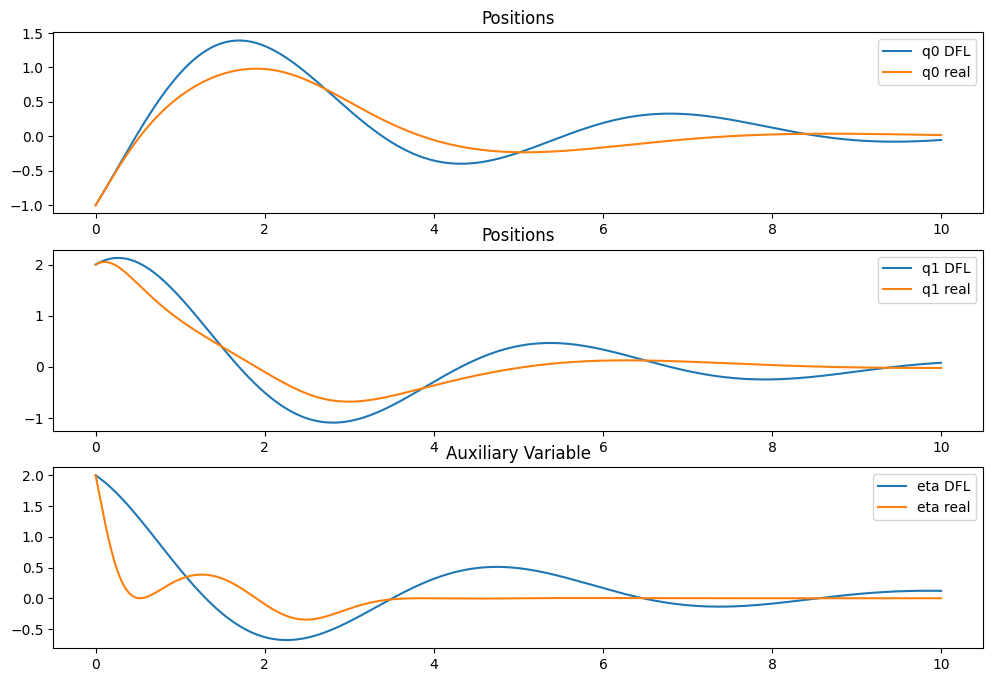

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
# sol.y = sol.y[:, :1000]
for i in range(2):
    ax[i].plot(ts[:len(lin_sol.y[i])], lin_sol.y[i], label=f"q{i} DFL")
    ax[i].set_title('Positions')
    ax[i].plot(ts[:len(sol.y[i])], sol.y[i], label=f"q{i} real")
    ax[i].legend()
eta_sol = np.array(
    [eta_fn(state_i) for state_i in sol.y.T]
).reshape(-1, 1)
ax[2].set_title('Auxiliary Variable')
ax[2].plot(ts[:len(lin_sol.y[-1])], lin_sol.y[-1], label=f"eta DFL")
ax[2].plot(ts[:len(eta_sol)], eta_sol, label="eta real")
ax[2].legend()
plt.show()

## Regions of Attraction

### LTI LQR

Now, let's analyse the following Lyapunov candidate:
$$V = \frac{1}{2} \eta^T P \eta,$$
where $P$ is a matrix, resulting from LTI LQR discrete control.

In [19]:
A_np = np.zeros(((3, 3)))
A_np[:2, :2] = A_x
A_np[:2, 2:] = A_eta
A_np[2:] = H_w_np

A = cs.SX(A_np)

In [20]:
from scipy.linalg import solve_continuous_lyapunov as lyap

Q_np = np.eye(3)
P_np = lyap(A_np.T, -Q_np)
P = cs.SX(P_np)

In [21]:
P

SX(
[[1.91373, 0.632102, -0.239062], 
 [0.632102, 2.06213, -1.01673], 
 [-0.239062, -1.01673, 2.90696]])

In [22]:
def sampling_roa(f, V, dV, x_bounds, N=100):
    x_min, x_max = x_bounds
    x_range = np.array(x_max) - np.array(x_min)
    n = np.shape(x_min)[0]

    c = np.inf
    ct = []

    for i in range(N):
        x_i = x_min + x_range*np.random.rand(n)
        dV_i = dV(x_i)
        V_i = V(x_i)
        if dV_i >= 0 and V_i <= c:
            c = V_i
            ct.append(c)  
    
    return c, np.array(ct)

In [23]:
V = 1/2 * full_state.T @ P @ full_state
V_fn = cs.Function('V', [state], [V])
V_dot_fn = cs.Function('V_dot', [state], [cs.jacobian(V, state) @ f(state)])

In [24]:
state_lims = np.array([
    [-2, -2],
    [2, 2]
])

r_dfl, _ = sampling_roa(f, V_fn, V_dot_fn, state_lims, N = 10000)
levelset_dfl = cs.Function('V_level', [state], [V - r_dfl])
r_dfl

DM(1.18712)

In [25]:
jacobian = cs.Function('jacobian', [state], [cs.jacobian(f(state), state)])
A_taylor = jacobian(np.zeros(2))
Q_taylor = np.eye(2)

P_taylor = lyap(A_taylor.T, -Q_taylor)

V_taylor = 1/2 * state.T @ P_taylor @ state
V_taylor_fn = cs.Function('V_taylor', [state], [V_taylor])
V_taylor_dot_fn = cs.Function('V_taylor', [state], [cs.jacobian(V_taylor, state) @ f(state)])

In [26]:
r_taylor, _ = sampling_roa(f, V_taylor_fn, V_taylor_dot_fn, state_lims, N = 10000)
levelset_taylor = cs.Function('V_level', [state], [V_taylor - r_taylor])
r_taylor

DM(1.1771)

In [27]:
phase_portrait(f, x_range=[3, 3], density=1.2)
YfНо есть корреляция: чем лучше зафиттился DFL, тем лучше этот регион
draw_elipse(
    [-3, 3], 
    f = levelset_taylor, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'red',
    } 
)

draw_elipse(
    [-3, 3], 
    f = levelset_dfl, 
    cs_func = True, 
    args=tuple(),
    plt_args = {
        'linewidths': 2,
        'colors': 'blue',
    } 
)

plt.show()

SyntaxError: invalid syntax (1120184662.py, line 2)